In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.0001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_00001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 10:47 - loss: 0.1037 - STD: 1.5798e-04 - MAE: 0.3113

 16/632 [..............................] - ETA: 2s - loss: 0.0399 - STD: 4.4448e-04 - MAE: 0.1726   

 32/632 [>.............................] - ETA: 2s - loss: 0.0271 - STD: 4.9504e-04 - MAE: 0.1176

 47/632 [=>............................] - ETA: 1s - loss: 0.0227 - STD: 5.4314e-04 - MAE: 0.0994

 61/632 [=>............................] - ETA: 2s - loss: 0.0203 - STD: 6.6132e-04 - MAE: 0.0929

 73/632 [==>...........................] - ETA: 2s - loss: 0.0191 - STD: 8.0642e-04 - MAE: 0.0898

 87/632 [===>..........................] - ETA: 2s - loss: 0.0180 - STD: 0.0010 - MAE: 0.0864    

100/632 [===>..........................] - ETA: 1s - loss: 0.0172 - STD: 0.0012 - MAE: 0.0840

113/632 [====>.........................] - ETA: 1s - loss: 0.0166 - STD: 0.0015 - MAE: 0.0821

129/632 [=====>........................] - ETA: 1s - loss: 0.0159 - STD: 0.0019 - MAE: 0.0802

144/632 [=====>........................] - ETA: 1s - loss: 0.0156 - STD: 0.0023 - MAE: 0.0791

160/632 [======>.......................] - ETA: 1s - loss: 0.0152 - STD: 0.0029 - MAE: 0.0779

176/632 [=======>......................] - ETA: 1s - loss: 0.0148 - STD: 0.0037 - MAE: 0.0767

190/632 [========>.....................] - ETA: 1s - loss: 0.0145 - STD: 0.0045 - MAE: 0.0759

207/632 [========>.....................] - ETA: 1s - loss: 0.0141 - STD: 0.0057 - MAE: 0.0747

223/632 [=========>....................] - ETA: 1s - loss: 0.0138 - STD: 0.0071 - MAE: 0.0735

240/632 [==========>...................] - ETA: 1s - loss: 0.0134 - STD: 0.0091 - MAE: 0.0722

256/632 [===========>..................] - ETA: 1s - loss: 0.0130 - STD: 0.0114 - MAE: 0.0710

272/632 [===========>..................] - ETA: 1s - loss: 0.0126 - STD: 0.0139 - MAE: 0.0697

288/632 [============>.................] - ETA: 1s - loss: 0.0122 - STD: 0.0167 - MAE: 0.0684

305/632 [=============>................] - ETA: 1s - loss: 0.0118 - STD: 0.0197 - MAE: 0.0672

318/632 [==============>...............] - ETA: 1s - loss: 0.0116 - STD: 0.0220 - MAE: 0.0663

330/632 [==============>...............] - ETA: 1s - loss: 0.0113 - STD: 0.0240 - MAE: 0.0655

342/632 [===============>..............] - ETA: 1s - loss: 0.0111 - STD: 0.0260 - MAE: 0.0647

354/632 [===============>..............] - ETA: 0s - loss: 0.0108 - STD: 0.0279 - MAE: 0.0639

366/632 [================>.............] - ETA: 0s - loss: 0.0106 - STD: 0.0297 - MAE: 0.0632

378/632 [================>.............] - ETA: 0s - loss: 0.0104 - STD: 0.0315 - MAE: 0.0625

392/632 [=================>............] - ETA: 0s - loss: 0.0102 - STD: 0.0334 - MAE: 0.0617

404/632 [==================>...........] - ETA: 0s - loss: 0.0100 - STD: 0.0350 - MAE: 0.0610

420/632 [==================>...........] - ETA: 0s - loss: 0.0097 - STD: 0.0371 - MAE: 0.0602

435/632 [===================>..........] - ETA: 0s - loss: 0.0095 - STD: 0.0390 - MAE: 0.0594

449/632 [====================>.........] - ETA: 0s - loss: 0.0093 - STD: 0.0406 - MAE: 0.0588

455/632 [====================>.........] - ETA: 0s - loss: 0.0093 - STD: 0.0413 - MAE: 0.0585

471/632 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0431 - MAE: 0.0578

483/632 [=====================>........] - ETA: 0s - loss: 0.0089 - STD: 0.0443 - MAE: 0.0573

495/632 [======================>.......] - ETA: 0s - loss: 0.0088 - STD: 0.0455 - MAE: 0.0568

509/632 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0469 - MAE: 0.0562

526/632 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.0484 - MAE: 0.0555

544/632 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.0500 - MAE: 0.0549

561/632 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.0514 - MAE: 0.0543

578/632 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0527 - MAE: 0.0538

594/632 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.0539 - MAE: 0.0532

611/632 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.0550 - MAE: 0.0527

628/632 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0561 - MAE: 0.0522

632/632 [==============================] - 4s 5ms/step - loss: 0.0075 - STD: 0.0564 - MAE: 0.0521 - val_loss: 0.0039 - val_STD: 0.0607 - val_MAE: 0.0404


Epoch 2/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0025 - STD: 0.0942 - MAE: 0.0328

 17/632 [..............................] - ETA: 1s - loss: 0.0027 - STD: 0.0984 - MAE: 0.0343 

 34/632 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.0985 - MAE: 0.0340

 47/632 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0983 - MAE: 0.0340

 61/632 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0982 - MAE: 0.0339

 78/632 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.0988 - MAE: 0.0338

 96/632 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.0988 - MAE: 0.0337

112/632 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0987 - MAE: 0.0337

127/632 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0985 - MAE: 0.0335

140/632 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0986 - MAE: 0.0335

158/632 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0988 - MAE: 0.0334

175/632 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0990 - MAE: 0.0333

192/632 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0991 - MAE: 0.0333

209/632 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0992 - MAE: 0.0332

225/632 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0995 - MAE: 0.0331

238/632 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0995 - MAE: 0.0330

254/632 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0996 - MAE: 0.0329

270/632 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0997 - MAE: 0.0329

286/632 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0997 - MAE: 0.0328

302/632 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0997 - MAE: 0.0327

315/632 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0998 - MAE: 0.0327

330/632 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0999 - MAE: 0.0326

343/632 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1000 - MAE: 0.0326

355/632 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1000 - MAE: 0.0325

369/632 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1000 - MAE: 0.0325

387/632 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1001 - MAE: 0.0324

403/632 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1001 - MAE: 0.0323

418/632 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1003 - MAE: 0.0323

430/632 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1003 - MAE: 0.0322

445/632 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0322

457/632 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0321

469/632 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0321

482/632 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0320

495/632 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0320

511/632 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0319

528/632 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1005 - MAE: 0.0318

545/632 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1006 - MAE: 0.0318

561/632 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1006 - MAE: 0.0317

578/632 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1008 - MAE: 0.0317

595/632 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1008 - MAE: 0.0316

612/632 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1007 - MAE: 0.0316

628/632 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1008 - MAE: 0.0315

632/632 [==============================] - 2s 4ms/step - loss: 0.0022 - STD: 0.1008 - MAE: 0.0315 - val_loss: 0.0021 - val_STD: 0.0732 - val_MAE: 0.0319


Epoch 3/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0315

 13/632 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0294 

 26/632 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0295

 42/632 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0294

 58/632 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0294

 74/632 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0294

 90/632 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

107/632 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0292

123/632 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0292

139/632 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0291

157/632 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0291

174/632 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0291

191/632 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0291

207/632 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0291

224/632 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0290

235/632 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0290

248/632 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0290

264/632 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0289

278/632 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0289

293/632 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0289

309/632 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0289

325/632 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0288

341/632 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0288

358/632 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0288

375/632 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

392/632 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

409/632 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

427/632 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

444/632 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0287

461/632 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

479/632 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

497/632 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

515/632 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0286

533/632 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0286

551/632 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0285

568/632 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

585/632 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

602/632 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0285

619/632 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

632/632 [==============================] - 2s 3ms/step - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284 - val_loss: 0.0018 - val_STD: 0.0773 - val_MAE: 0.0296


Epoch 4/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0016 - STD: 0.1131 - MAE: 0.0277

 18/632 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0278 

 35/632 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

 53/632 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

 70/632 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0278

 88/632 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0278

105/632 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0279

120/632 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0278

136/632 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0279

152/632 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0278

169/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0278

186/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0278

202/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

218/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

235/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0277

251/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

267/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

284/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

300/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

317/632 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

333/632 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

350/632 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

367/632 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

383/632 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

399/632 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

415/632 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

431/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

448/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

462/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

475/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

489/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

505/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

520/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

533/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

548/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

565/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

580/632 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

593/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

605/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

618/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

631/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

632/632 [==============================] - 2s 4ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274 - val_loss: 0.0016 - val_STD: 0.0775 - val_MAE: 0.0285


Epoch 5/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

 17/632 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269 

 33/632 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0268

 45/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0269

 58/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0269

 72/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0270

 84/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

 96/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0270

111/632 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

127/632 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

143/632 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

160/632 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

177/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

193/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

208/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

225/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

238/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

251/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

264/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

279/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

296/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

312/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

329/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

346/632 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

361/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

379/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

396/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

412/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

429/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

446/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

463/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

480/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

497/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

510/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

523/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

536/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

551/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

566/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

583/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

599/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

613/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

625/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

632/632 [==============================] - 2s 4ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268 - val_loss: 0.0017 - val_STD: 0.0794 - val_MAE: 0.0288


Epoch 6/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0013 - STD: 0.0978 - MAE: 0.0254

 16/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0266 

 33/632 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0266

 49/632 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0266

 62/632 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0265

 74/632 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0265

 86/632 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0265

 98/632 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0265

113/632 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

128/632 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

143/632 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

158/632 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

170/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

182/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

196/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

209/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

223/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

235/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

247/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

259/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

273/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

289/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

303/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

318/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

331/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

344/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

357/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

369/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

382/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

394/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

408/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

424/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

441/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

456/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

468/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

480/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

496/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

514/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

530/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

546/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

562/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

578/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

594/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

610/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

626/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

632/632 [==============================] - 3s 4ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.0786 - val_MAE: 0.0281


Epoch 7/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0015 - STD: 0.1119 - MAE: 0.0266

 14/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268 

 29/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

 46/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

 64/632 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

 82/632 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

 96/632 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

108/632 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

122/632 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0265

138/632 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0265

154/632 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

170/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

186/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

202/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

219/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

236/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

252/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

265/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

278/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

293/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

306/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

319/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

334/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

346/632 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

359/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

370/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

382/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

395/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

407/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

419/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

433/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

447/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

460/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

473/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

485/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

497/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

510/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

524/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

537/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

549/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

561/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

573/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

585/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

597/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

613/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

629/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

632/632 [==============================] - 3s 4ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263 - val_loss: 0.0017 - val_STD: 0.0807 - val_MAE: 0.0288


Epoch 8/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1105 - MAE: 0.0259

 19/632 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260 

 36/632 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

 53/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

 69/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

 85/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

102/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

116/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

131/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

146/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

159/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

172/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

185/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

199/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

212/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

228/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0261

244/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0261

257/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0261

270/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

282/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

294/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

307/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

320/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

333/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

348/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

363/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

376/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

389/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

403/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

417/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

432/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

446/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

462/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

474/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

487/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

500/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

513/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

525/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

538/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

550/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

562/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

576/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

590/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

604/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

618/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

631/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

632/632 [==============================] - 3s 4ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262 - val_loss: 0.0015 - val_STD: 0.0796 - val_MAE: 0.0281


Epoch 9/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0269

 15/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0267 

 29/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

 42/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

 55/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

 69/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

 84/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

 98/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

115/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

129/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

142/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

156/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

171/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

186/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

202/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

219/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

233/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

245/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

259/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

276/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

293/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

311/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

329/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

347/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

360/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

377/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

394/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

409/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

421/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

434/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

449/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

467/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

484/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

501/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

518/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

535/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

552/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

570/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

589/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

605/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

621/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

632/632 [==============================] - 2s 4ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261 - val_loss: 0.0017 - val_STD: 0.0817 - val_MAE: 0.0289


Epoch 10/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0017 - STD: 0.1162 - MAE: 0.0277

 18/632 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0260 

 37/632 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0261

 56/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

 73/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0261

 91/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

110/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

128/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

146/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

164/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

182/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

200/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

218/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

236/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

254/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

272/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

290/632 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

308/632 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

326/632 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

344/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

362/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

380/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

398/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

416/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

434/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

452/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

469/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

486/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

503/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

520/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

535/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

551/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

567/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

583/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

599/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

615/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

631/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

632/632 [==============================] - 2s 3ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259 - val_loss: 0.0017 - val_STD: 0.0825 - val_MAE: 0.0288


Epoch 11/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0013 - STD: 0.1110 - MAE: 0.0252

 15/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1088 - MAE: 0.0261 

 30/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0261

 47/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0261

 62/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0261

 75/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

 89/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

103/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

119/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

136/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

153/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

170/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

186/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

202/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

219/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

235/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

251/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

267/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

283/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

299/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

315/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

331/632 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

348/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

363/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

377/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

391/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

406/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

423/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

440/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

457/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

474/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

491/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

508/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

525/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

543/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

559/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

574/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

590/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

606/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

621/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

632/632 [==============================] - 2s 4ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259 - val_loss: 0.0019 - val_STD: 0.0826 - val_MAE: 0.0304


Epoch 12/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0014 - STD: 0.1178 - MAE: 0.0262

 15/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260 

 30/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

 43/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

 57/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

 70/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

 84/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

 98/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

112/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

127/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

142/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

155/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

172/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

188/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

202/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

215/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

229/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

244/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

259/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

272/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

285/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

297/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

309/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

321/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

333/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

345/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

360/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

374/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

388/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

401/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

415/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

427/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

439/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

452/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

465/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

478/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

491/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

504/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

516/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

529/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

542/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

555/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

568/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

581/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

596/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

609/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

624/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

632/632 [==============================] - 3s 4ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257 - val_loss: 0.0016 - val_STD: 0.0813 - val_MAE: 0.0280


Epoch 13/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0266

 16/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0251 

 31/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0254

 44/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0255

 57/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0255

 70/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0255

 84/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

 97/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0255

110/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0256

123/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0256

136/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0256

150/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

163/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

177/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

190/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

202/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

214/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

228/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

243/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

259/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

276/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

294/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

311/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

328/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

346/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

364/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

382/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

399/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

416/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

434/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

450/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

467/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

484/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

501/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

518/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

535/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

552/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

569/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

586/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

603/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

620/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

632/632 [==============================] - 2s 4ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257 - val_loss: 0.0016 - val_STD: 0.0819 - val_MAE: 0.0281


Epoch 14/10000


  1/632 [..............................] - ETA: 18s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0262

 14/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258 

 26/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0256

 41/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1078 - MAE: 0.0257

 56/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0257

 72/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

 89/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0257

104/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0257

117/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0256

130/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0256

143/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

156/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

169/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

181/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

195/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

209/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

221/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

233/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

246/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

259/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

272/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

286/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

300/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

313/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

325/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

337/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

350/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

364/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

377/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

390/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

403/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

416/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

429/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

442/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

455/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

467/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

480/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

493/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

507/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

521/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

535/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

549/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

566/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

579/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

593/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

608/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

621/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

632/632 [==============================] - 3s 4ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256 - val_loss: 0.0016 - val_STD: 0.0827 - val_MAE: 0.0280


Epoch 15/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0015 - STD: 0.1000 - MAE: 0.0262

 17/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0257 

 30/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0256

 41/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0257

 54/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0257

 66/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

 79/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

 94/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

108/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

125/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

138/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

151/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

166/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

179/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

191/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

203/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

216/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

230/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

243/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

255/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

267/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

280/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

296/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

312/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

329/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

342/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

357/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

372/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

384/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

396/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

408/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

421/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

434/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

447/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

460/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

473/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

486/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

500/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

512/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

525/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

537/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

549/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

563/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

578/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

594/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

611/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

628/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

632/632 [==============================] - 3s 4ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256 - val_loss: 0.0017 - val_STD: 0.0824 - val_MAE: 0.0286


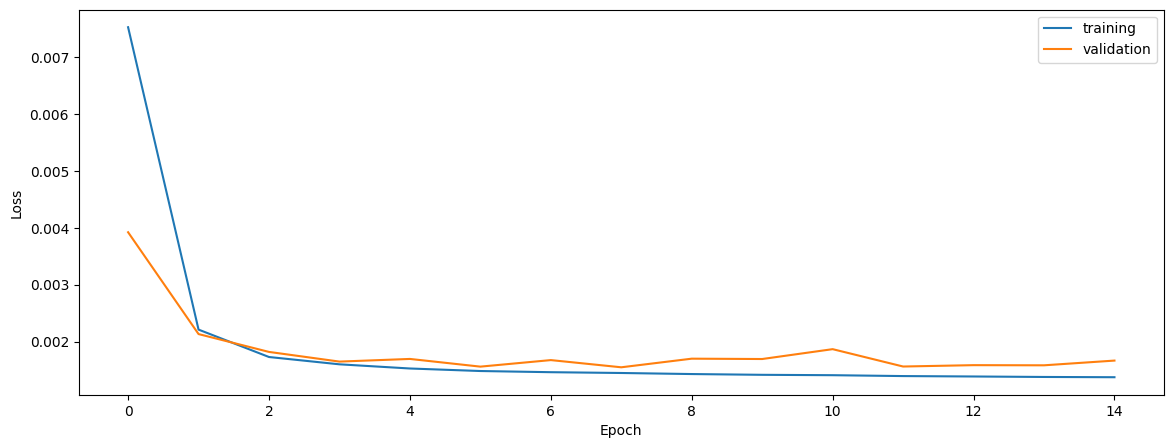

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


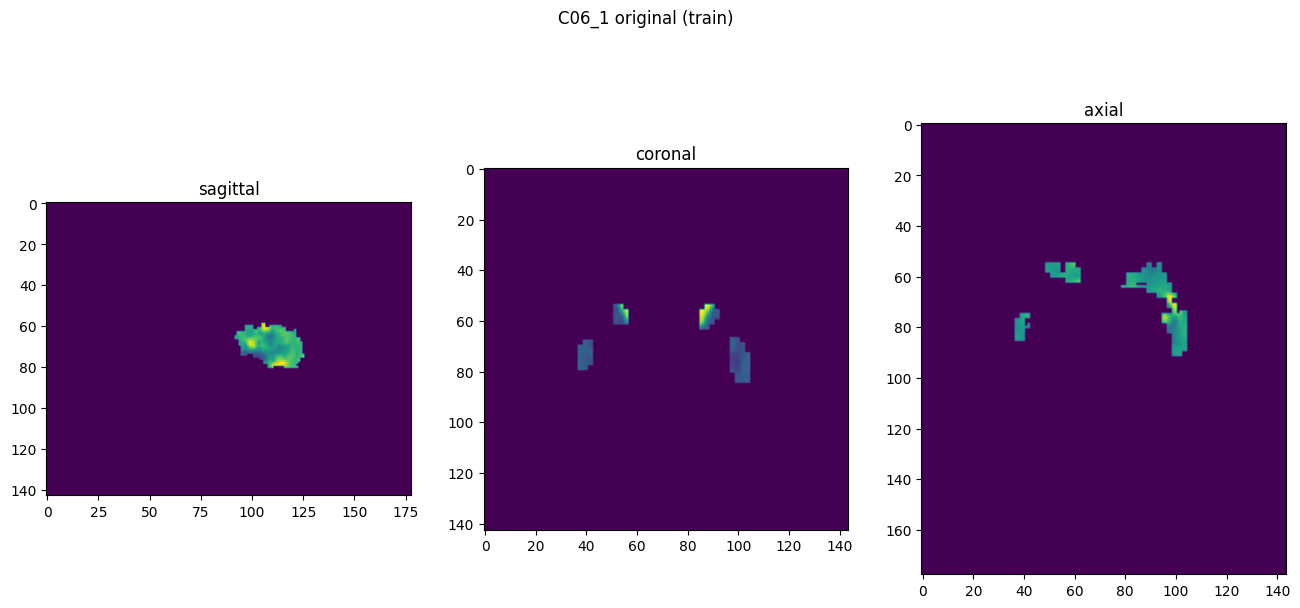

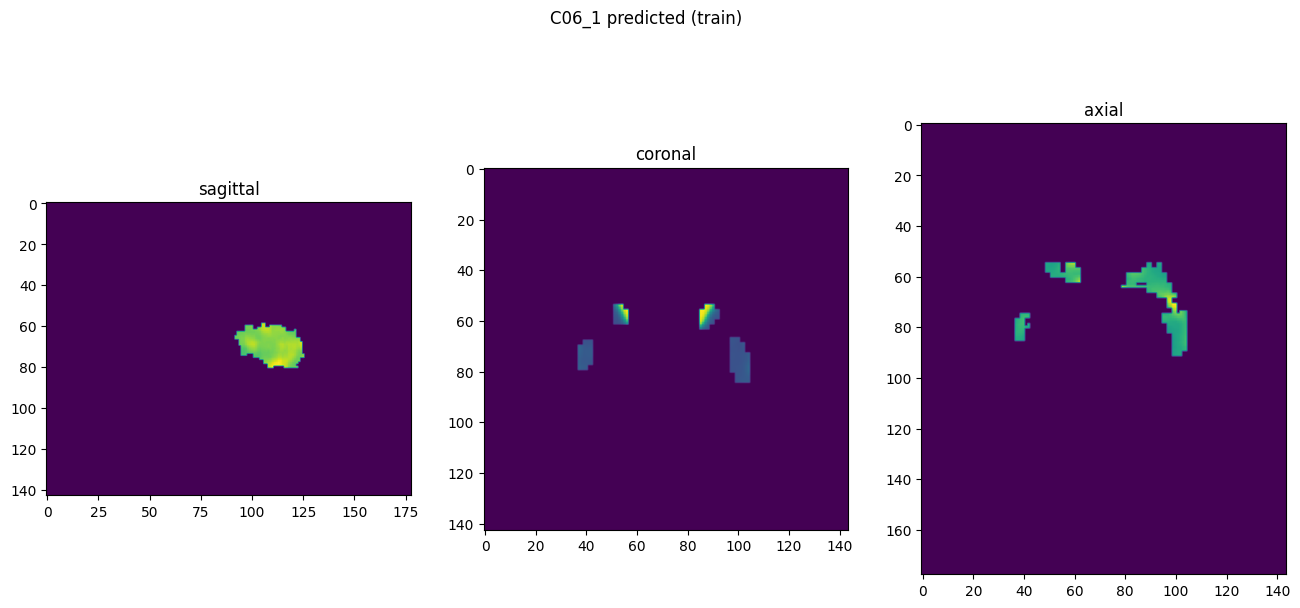

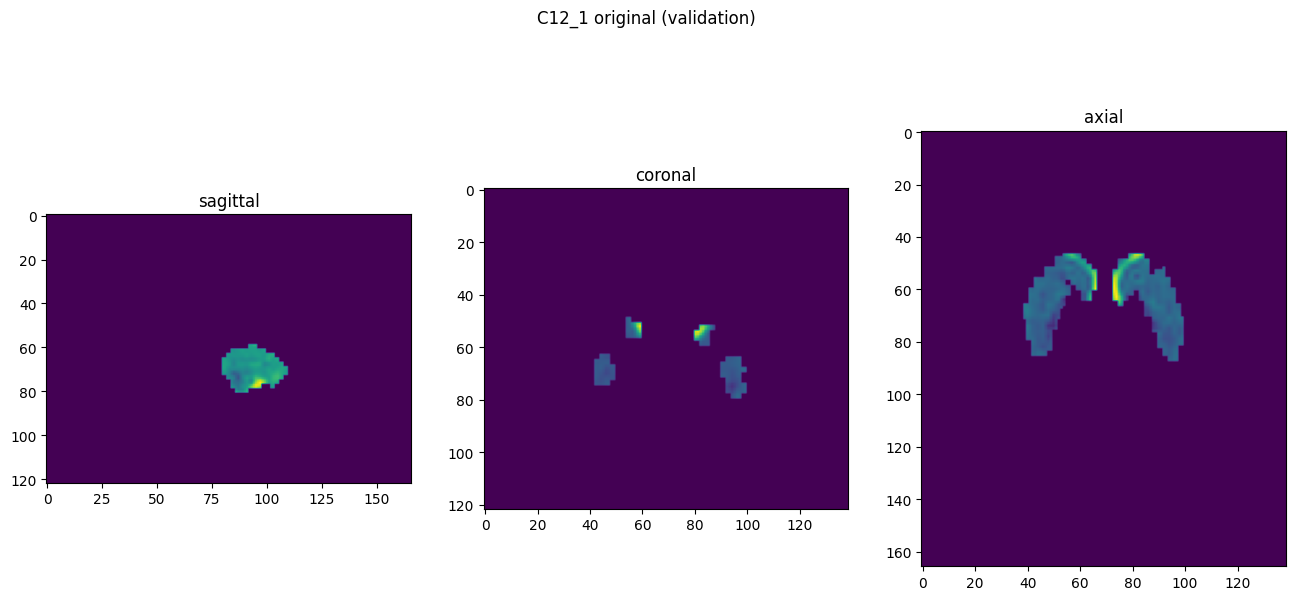

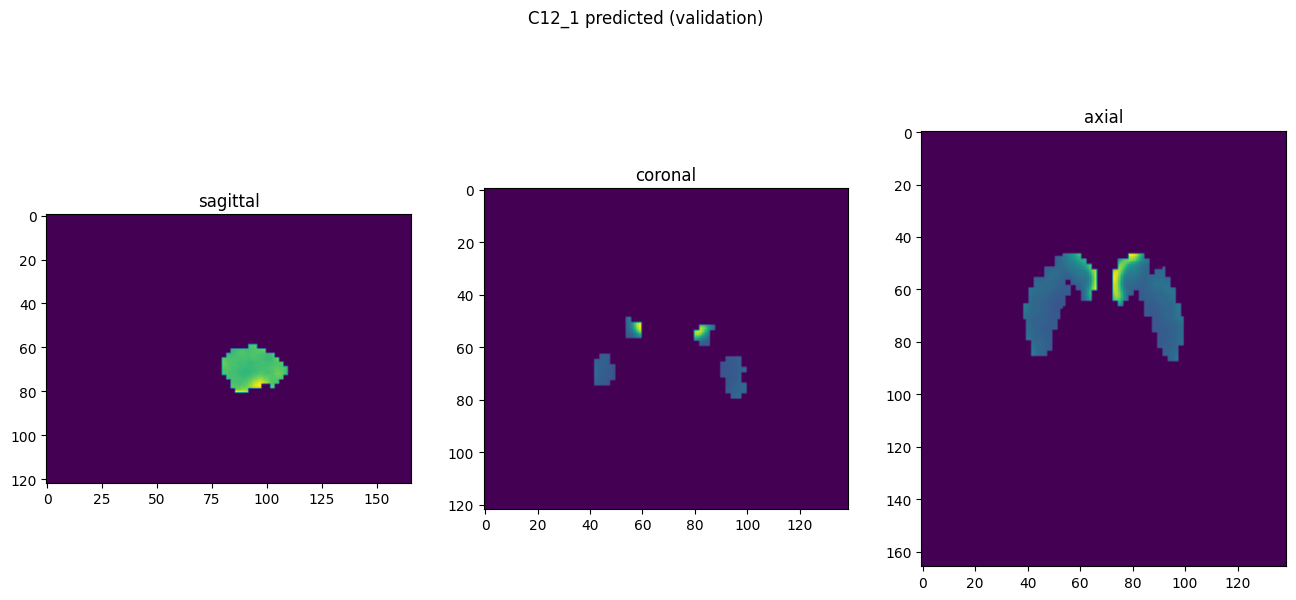

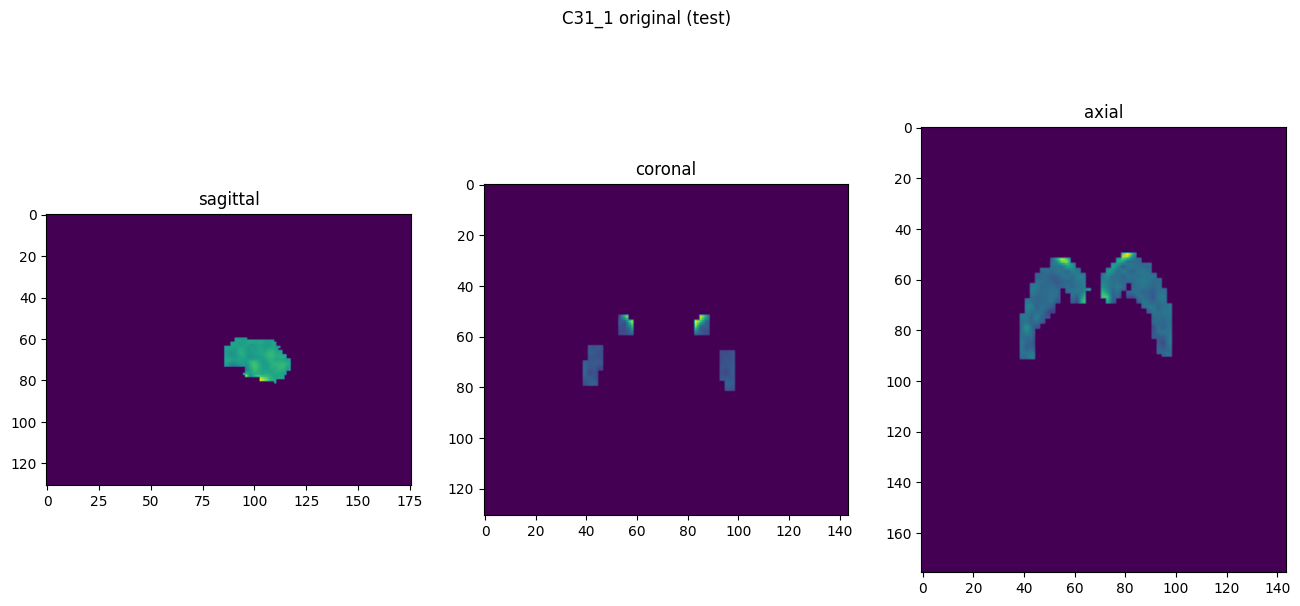

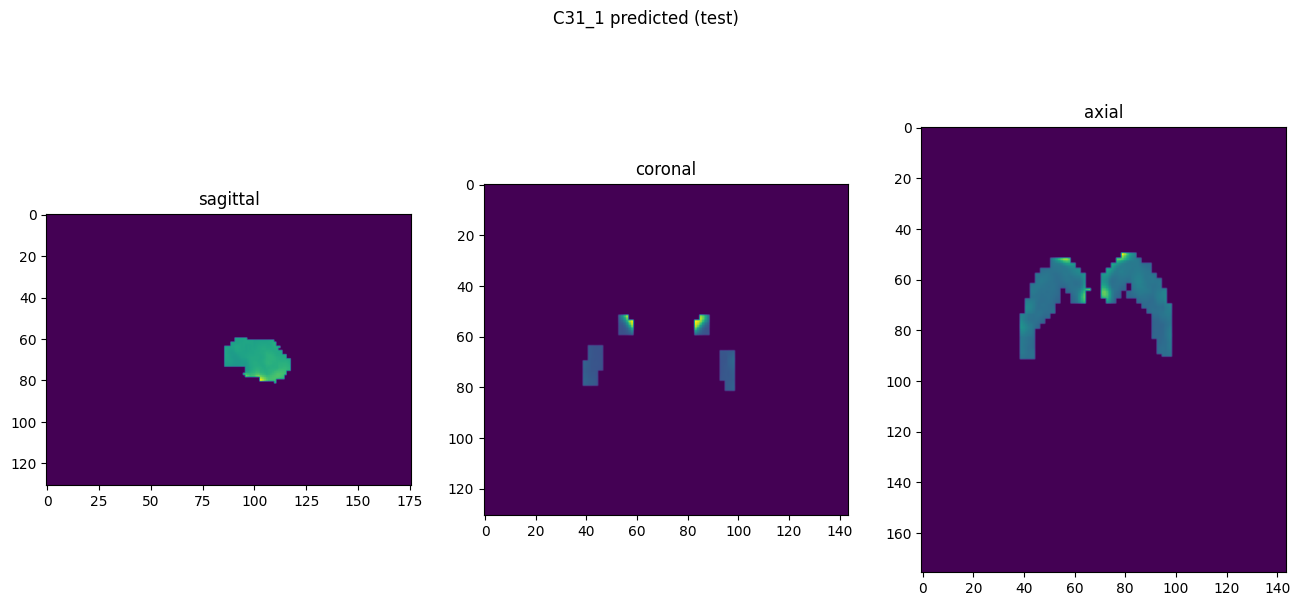

In [10]:
showResults(model, gen, threshold=None, background=False)